In [2]:
import pandas as pd
import mysql.connector



In [3]:
customers = pd.read_csv('C:\\vs\\global\\uncleaned data\\Customers.csv',encoding='unicode_escape')
products = pd.read_csv("C:\\vs\\global\\uncleaned data\\Products.csv", encoding="unicode_escape")
sales = pd.read_csv("C:\\vs\\global\\uncleaned data\\Sales.csv", encoding="unicode_escape")
stores = pd.read_csv("C:\\vs\\global\\uncleaned data\\Stores.csv", encoding="unicode_escape")
exchange_rates = pd.read_csv("C:\\vs\\global\\uncleaned data\\Exchange_Rates.csv", encoding="unicode_escape")



In [4]:
def clean_data(df):
    # Handle missing values
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    return df

customers = clean_data(customers)
products = clean_data(products)
sales = clean_data(sales)
stores = clean_data(stores)
exchange_rates = clean_data(exchange_rates)

In [5]:
# Save the cleaned data to a CSV file
customers.to_csv("C:\\vs\\global\\cleaned data\\Customers1.csv", encoding="utf-8", index=False)
sales.to_csv("C:\\vs\\global\\cleaned data\\Sales1.csv", encoding="utf-8", index=False)
products.to_csv("C:\\vs\\global\\cleaned data\\Products1.csv", encoding="utf-8", index=False)
stores.to_csv("C:\\vs\\global\\cleaned data\\Stores1.csv", encoding="utf-8", index=False)
exchange_rates.to_csv("C:\\vs\\global\\cleaned data\\Exchange_rates.csv", encoding="utf-8", index=False)


In [6]:
# Merging dataframes
merged_data = pd.merge(sales, customers, on="CustomerKey")
merged_data = pd.merge(merged_data, products, on="ProductKey")
merged_data = pd.merge(merged_data, stores, on="StoreKey")


In [7]:
# Converting date columns to datetime format
merged_data["Order Date"] = pd.to_datetime(merged_data["Order Date"])
merged_data["Delivery Date"] = pd.to_datetime(merged_data["Delivery Date"])
merged_data["Birthday"] = pd.to_datetime(merged_data["Birthday"])



In [8]:
# Handling exchange rates
exchange_rates.info()
exchange_rates["Date"] = pd.to_datetime(exchange_rates["Date"])
print(f"Date: {exchange_rates['Date'].min(), exchange_rates['Date'].max()}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11215 entries, 0 to 11214
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      11215 non-null  object 
 1   Currency  11215 non-null  object 
 2   Exchange  11215 non-null  float64
dtypes: float64(1), object(2)
memory usage: 263.0+ KB
Date: (Timestamp('2015-01-01 00:00:00'), Timestamp('2021-02-20 00:00:00'))


In [9]:
# Merging exchange rates with merged data
merged_data = pd.merge(merged_data, exchange_rates, left_on="Order Date", right_on="Date", how="left")


In [10]:
# Save the merged data to a CSV file
merged_data.to_csv("merged_data.csv", encoding="utf-8", index=False)

In [11]:
merged_data = pd.read_csv("C:\\vs\\global\\merged_data.csv")
merged_data.head()

,Order Number,Line Item,Order Date,Delivery Date,CustomerKey,StoreKey,ProductKey,Quantity,Currency Code,Gender,...,Subcategory,CategoryKey,Category,Country_y,State_y,Square Meters,Open Date,Date,Currency,Exchange
0,366000,1,2016-01-01,2016-01-13,265598,10,1304,1,CAD,Male,...,Cameras & Camcorders Accessories,4,Cameras and camcorders,Canada,Nunavut,1210.0,4/4/2015,2016-01-01,USD,1.0000
1,366000,1,2016-01-01,2016-01-13,265598,10,1304,1,CAD,Male,...,Cameras & Camcorders Accessories,4,Cameras and camcorders,Canada,Nunavut,1210.0,4/4/2015,2016-01-01,CAD,1.3884
2,366000,1,2016-01-01,2016-01-13,265598,10,1304,1,CAD,Male,...,Cameras & Camcorders Accessories,4,Cameras and camcorders,Canada,Nunavut,1210.0,4/4/2015,2016-01-01,AUD,1.3683
3,366000,1,2016-01-01,2016-01-13,265598,10,1304,1,CAD,Male,...,Cameras & Camcorders Accessories,4,Cameras and camcorders,Canada,Nunavut,1210.0,4/4/2015,2016-01-01,EUR,0.9185
4,366000,1,2016-01-01,2016-01-13,265598,10,1304,1,CAD,Male,...,Cameras & Camcorders Accessories,4,Cameras and camcorders,Canada,Nunavut,1210.0,4/4/2015,2016-01-01,GBP,0.6742


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

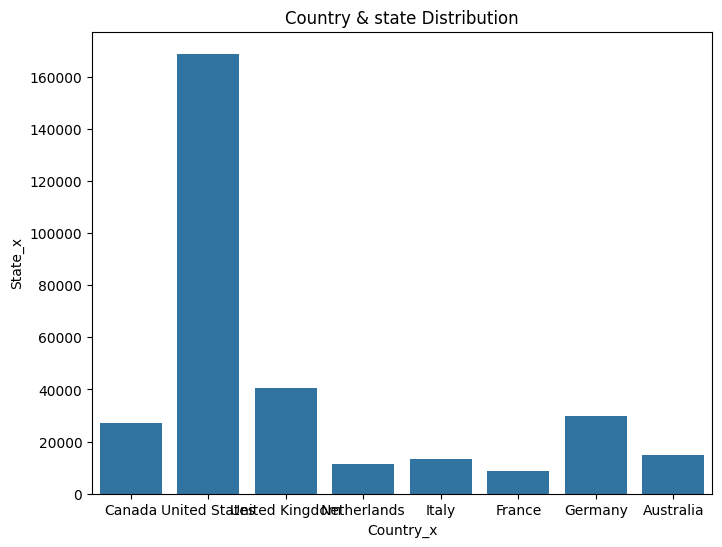

In [13]:
#Country&state Distribution

plt.figure(figsize=(8, 6))
sns.countplot(x='Country_x', data=merged_data)
plt.title('Country & state Distribution')
plt.xlabel('Country_x')
plt.ylabel('State_x')
plt.show()

In [14]:
# Connect to MySQL server
conn = mysql.connector.connect(host="localhost", user="root", password="NISHa1413@@@")

cursor = conn.cursor()
cursor.execute("CREATE DATABASE IF NOT EXISTS Global_Electronics")
cursor.close()
conn.close()

In [15]:
# Connect to the new database
conn = mysql.connector.connect(
    host="localhost", user="root", password="NISHa1413@@@", database="Global_Electronics"
)

cursor = conn.cursor()

In [16]:
# Get column names and types
columns = merged_data.columns
column_types = []

# Define a mapping from pandas dtype to SQL type
type_mapping = {
    "int64": "INT",
    "float64": "FLOAT",
    "object": "VARCHAR(255)",
    "datetime64[ns]": "DATETIME",
}

# Generate column type definitions
for col in columns:
    dtype = str(merged_data[col].dtype)
    sql_type = type_mapping.get(dtype, "VARCHAR(255)")
    column_types.append(f"`{col}` {sql_type}")

# Create SQL statement for table creation
create_table_query = f"""
CREATE TABLE IF NOT EXISTS Global_Electronics_Table (
    {', '.join(column_types)}
)
"""

cursor.execute(create_table_query)

In [17]:
# Prepare the INSERT INTO SQL statement
insert_query = f"""
INSERT INTO Global_Electronics_Table ({', '.join([f'`{col}`' for col in columns])})
VALUES ({', '.join(['%s'] * len(columns))})
"""

# Insert the data
for index, row in merged_data.iterrows():
    cursor.execute(insert_query, tuple(row))

# Commit the transaction
#conn.commit()

In [18]:
query = '''
        SELECT gender, 
        COUNT(*) AS count 
        FROM Global_Electronics_Table 
        GROUP BY gender
        '''
cursor.execute(query)
for table in cursor:
    print(table)

('Male', 318040)
('Female', 310800)


In [19]:
2.#-- countery wise customer count
query='''
        SELECT continent,Country_x,state_x,city, 
        COUNT(CustomerKey) AS count
        FROM Global_Electronics_Table 
        GROUP BY continent,Country_x,state_x,city
        ORDER BY count DESC'''
cursor.execute(query)
for table in cursor:
   print(table)

('North America', 'Canada', 'Ontario', 'Toronto', 6810)
('North America', 'United States', 'California', 'Los Angeles', 5790)
('North America', 'United States', 'New York', 'New York', 5690)
('North America', 'United States', 'Texas', 'Houston', 4380)
('North America', 'United States', 'Illinois', 'Chicago', 3680)
('North America', 'Canada', 'Quebec', 'Montreal', 3610)
('North America', 'United States', 'Pennsylvania', 'Philadelphia', 3570)
('North America', 'United States', 'Texas', 'Dallas', 2820)
('North America', 'Canada', 'Alberta', 'Calgary', 2670)
('North America', 'United States', 'Georgia', 'Atlanta', 2480)
('North America', 'United States', 'Michigan', 'Southfield', 2390)
('North America', 'United States', 'California', 'San Francisco', 2370)
('North America', 'United States', 'Washington', 'Seattle', 2350)
('North America', 'United States', 'Florida', 'Miami', 2230)
('North America', 'United States', 'California', 'Oakland', 2060)
('North America', 'United States', 'Michigan

In [20]:
#3. Analyze the distribution of customers based on age
query = '''
        SELECT YEAR(CURDATE()) - YEAR(Birthday) AS age, 
        COUNT(*) AS count 
        FROM Global_Electronics_Table 
        GROUP BY age 
        ORDER BY age
        '''
cursor.execute(query)
for table in cursor:
    print(table)

(22, 760)
(23, 12360)
(24, 10510)
(25, 9600)
(26, 10510)
(27, 8160)
(28, 9350)
(29, 8820)
(30, 9490)
(31, 9350)
(32, 9220)
(33, 10800)
(34, 9760)
(35, 8780)
(36, 8780)
(37, 9360)
(38, 9360)
(39, 9940)
(40, 8090)
(41, 8400)
(42, 10810)
(43, 9840)
(44, 10950)
(45, 8290)
(46, 9400)
(47, 10780)
(48, 8180)
(49, 7410)
(50, 9030)
(51, 9550)
(52, 9440)
(53, 10520)
(54, 7900)
(55, 9440)
(56, 10580)
(57, 8220)
(58, 8970)
(59, 11230)
(60, 9230)
(61, 9110)
(62, 9130)
(63, 10000)
(64, 8400)
(65, 9030)
(66, 9300)
(67, 9340)
(68, 9710)
(69, 9560)
(70, 10210)
(71, 8700)
(72, 8930)
(73, 9800)
(74, 9850)
(75, 9630)
(76, 9550)
(77, 7960)
(78, 9690)
(79, 11480)
(80, 7840)
(81, 10010)
(82, 8130)
(83, 9290)
(84, 7860)
(85, 8620)
(86, 9760)
(87, 10320)
(88, 8620)
(89, 7840)


In [21]:
#4. Query for total sales based on product subcategory
query = '''
    SELECT Subcategory, SUM(Quantity) as total_Sales
    FROM Global_Electronics_Table
    GROUP BY Subcategory
    ORDER BY total_Sales DESC
    LIMIT 5
'''
#cursor.execute(query)
#for table in cursor:
 #  print(table)
df = pd.read_sql_query(query, conn)
df

C:\Users\iswar\AppData\Local\Temp\ipykernel_16936\851692054.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,Subcategory,total_Sales
0,Movie DVD,288020.0
1,Desktops,206260.0
2,Bluetooth Headphones,136530.0
3,Download Games,115470.0
4,Boxed Games,110440.0


In [22]:
#5. view total sales for each product category
query = '''
    SELECT Category, SUM(Quantity) as total_Sales
    FROM Global_Electronics_Table
    GROUP BY Category
    ORDER BY total_Sales DESC
    LIMIT 5
'''

df = pd.read_sql_query(query, conn)
df

C:\Users\iswar\AppData\Local\Temp\ipykernel_16936\615744810.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,Category,total_Sales
0,Computers,441510.0
1,Cell phones,314770.0
2,"Music, Movies and Audio Books",288020.0
3,Audio,234900.0
4,Games and Toys,225910.0


In [23]:
#6. Query for top 5 countries with high Average sales
query = '''
    SELECT Country_y as Country, AVG(Quantity) as average_Sales
    FROM Global_Electronics_Table
    GROUP BY Country
    ORDER BY average_Sales DESC
    LIMIT 5
'''

df = pd.read_sql_query(query, conn)
df

C:\Users\iswar\AppData\Local\Temp\ipykernel_16936\1354366229.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,Country,average_Sales
0,Netherlands,3.2521
1,Germany,3.1918
2,Italy,3.1740
3,Australia,3.1517
4,United States,3.1496


In [24]:
#7.Count the brand
query = '''
        SELECT Brand, 
        COUNT(*) AS count 
        FROM Global_Electronics_Table 
        GROUP BY Brand
        '''
cursor.execute(query)
for table in cursor:
    print(table)

('Contoso', 159530)
('A. Datum', 18340)
('Fabrikam', 35600)
('Adventure Works', 63820)
('The Phone Company', 60620)
('Proseware', 29950)
('Wide World Importers', 86800)
('Tailspin Toys', 54570)
('Southridge Video', 78870)
('Litware', 16630)
('Northwind Traders', 24110)


In [25]:
#8.Sum of quantity by using productkey
query = '''
    SELECT ProductKey, SUM(Quantity) as total_Sales
    FROM Global_Electronics_Table 
    GROUP BY ProductKey
    ORDER BY total_Sales DESC
'''
cursor.execute(query)
for table in cursor:
    print(table)


(444, Decimal('5500'))
(458, Decimal('5380'))
(424, Decimal('5210'))
(434, Decimal('5210'))
(425, Decimal('5200'))
(423, Decimal('5140'))
(446, Decimal('5090'))
(440, Decimal('5070'))
(448, Decimal('5050'))
(452, Decimal('5050'))
(435, Decimal('5050'))
(419, Decimal('4930'))
(436, Decimal('4900'))
(416, Decimal('4810'))
(417, Decimal('4800'))
(453, Decimal('4800'))
(428, Decimal('4790'))
(420, Decimal('4770'))
(427, Decimal('4760'))
(421, Decimal('4640'))
(460, Decimal('4640'))
(422, Decimal('4620'))
(455, Decimal('4620'))
(450, Decimal('4600'))
(439, Decimal('4580'))
(451, Decimal('4560'))
(430, Decimal('4550'))
(449, Decimal('4530'))
(433, Decimal('4510'))
(456, Decimal('4480'))
(432, Decimal('4390'))
(57, Decimal('4310'))
(418, Decimal('4300'))
(454, Decimal('4280'))
(457, Decimal('4240'))
(443, Decimal('4210'))
(442, Decimal('4150'))
(459, Decimal('4090'))
(429, Decimal('4050'))
(1573, Decimal('4040'))
(1612, Decimal('4010'))
(437, Decimal('4000'))
(426, Decimal('3920'))
(438, Deci

In [26]:
#9.Count of category by using color
query = '''
    SELECT Color,  
    COUNT(*) AS count 
    FROM Global_Electronics_Table 
    GROUP BY Color
'''
cursor.execute(query)
for table in cursor:
    print(table)

('White', 117740)
('Silver', 117850)
('Black', 165390)
('Orange', 7900)
('Blue', 37460)
('Gold', 18950)
('Brown', 19920)
('Red', 38380)
('Green', 13060)
('Purple', 3110)
('Grey', 47600)
('Yellow', 16430)
('Azure', 2110)
('Pink', 20200)
('Silver Grey', 2030)
('Transparent', 710)


In [28]:
#10.query for top 5 Store sizes with maximum Sale quantity
query = '''
    select `Square Meters`, sum(Quantity) as Total_Sales
    from Global_Electronics_Table
    group by `Square Meters`
    order by Total_Sales desc
    limit 5
'''


cursor.execute(query)
for table in cursor:
    print(table)

(2000.0, Decimal('501520'))
(840.0, Decimal('452970'))
(2100.0, Decimal('108730'))
(1260.0, Decimal('82080'))
(1120.0, Decimal('66130'))
